In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import lya_utils as ly
import jphot as jp

In [ ]:
# Gauss test 
p = jp.photonlist('PhotICs_Gauss.dat','',load=False)
p.load_ic(stars=True)
nphot_per_packet = p.nRealPhotons / p.nphoton # nb of real phot /s / MC phot
lbda = ly.clight / p.nu_star * 1e8  # [A]
ener = nphot_per_packet * ly.h_cgs * p.nu_ic  # [erg/s/MC phot]

# construct spectrum (in star-particle frame)
h,edges = np.histogram(lbda,bins=100,weights=ener)
bin_centers = 0.5*(edges[:-1]+edges[1:])
dlbda = bin_centers[1]-bin_centers[0]
h = h / dlbda # erg/s/A
plt.figure(figsize=(12,8))
plt.plot(bin_centers,h,color='SlateBlue',alpha=0.8)
plt.ylabel(r'$F_\lambda(\lambda)\ [erg/s/\AA]$',fontsize=15)
plt.xlabel(r'$\lambda\ [\AA]$',fontsize=15)

# add analytic expression (make sure parameters are the same as in the params_PFS_test_Gauss.txt)
l0 = 1216.
sigma_kms = 20.
sigma_Ang = sigma_kms * 1e5 / ly.clight * l0 
x = np.linspace(l0-5.*sigma_Ang,l0+5.*sigma_Ang,100)
f = 1./np.sqrt(2.*np.pi*sigma_Ang**2)*np.exp(-(x-l0)**2/2/sigma_Ang**2)
f = f * p.nRealPhotons * ly.h_cgs * ly.clight / (l0*1e-8)
plt.plot(x,f,linewidth=1,alpha=0.8,color='FireBrick')

In [ ]:
# Power Law test 
p = jp.photonlist('PhotICs_PowLaw.dat','',load=False)
p.load_ic(stars=True)
nphot_per_packet = p.nRealPhotons / p.nphoton # nb of real phot /s / MC phot
lbda = ly.clight / p.nu_star * 1e8  # [A]
ener = nphot_per_packet * ly.h_cgs * p.nu_ic  # [erg/s/MC phot]

# construct spectrum (in star-particle frame)
h,edges = np.histogram(lbda,bins=300,weights=ener)
bin_centers = 0.5*(edges[:-1]+edges[1:])
dlbda = bin_centers[1]-bin_centers[0]
h = h / dlbda # erg/s/A
plt.figure(figsize=(12,8))
plt.plot(bin_centers,h,color='SlateBlue',alpha=0.8)
plt.ylabel(r'$F_\lambda(\lambda)\ [erg/s/\AA]$',fontsize=15)
plt.xlabel(r'$\lambda\ [\AA]$',fontsize=15)

# plot analytic solution
# here, parameters should be the same as in params_PFS_test_PowLaw.txt (for l1 and l2) and the 
# beta and l0 values should match those in the file TestPhotTable_PowLaw.txt
beta = -2.5
l0 = 1216.
l1 = 1120.
l2 = 1320.
if beta == -2:
    F_0 = p.nRealPhotons * ly.h_cgs * ly.clight / (l0*1e-8) / l0 / np.log(l2/l1)
else:
    F_0 = p.nRealPhotons * ly.h_cgs * ly.clight / (l0*1e-8) / l0 * (2.+beta) / ((l2/l0)**(beta+2) - (l1/l0)**(beta+2))
x = np.linspace(l1,l2,num=100)
f = F_0*(x/l0)**(beta)
plt.plot(x,f,linewidth=1,alpha=0.8,color='FireBrick')

(971.84794902638328, 1508.1517288454338)

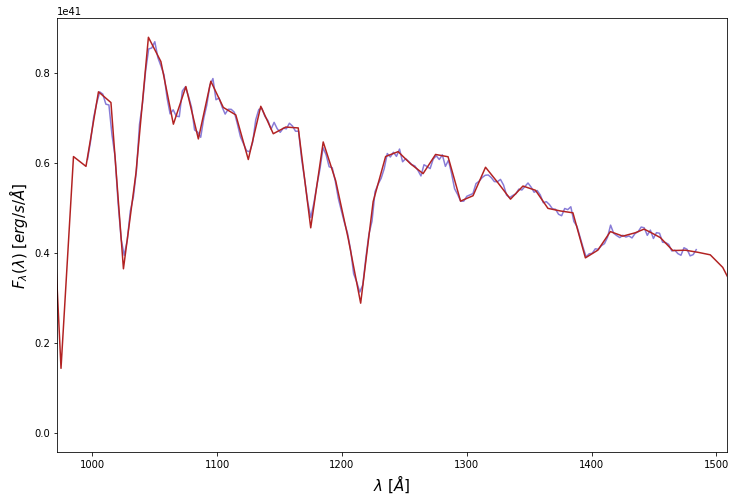

In [36]:
# Table test 
iage = 80
imet = 3

p = jp.photonlist('PhotICs_Table.dat','',load=False)
p.load_ic(stars=True)
nphot_per_packet = p.nRealPhotons / p.nphoton # nb of real phot /s / MC phot
lbda = ly.clight / p.nu_star * 1e8  # [A]
ener = nphot_per_packet * ly.h_cgs * p.nu_ic  # [erg/s/MC phot]
# construct spectrum (in star-particle frame)
h,edges = np.histogram(lbda,bins=200,weights=ener)
bin_centers = 0.5*(edges[:-1]+edges[1:])
dlbda = bin_centers[1]-bin_centers[0]
h = h / dlbda # erg/s/A
plt.figure(figsize=(12,8))
plt.plot(bin_centers,h,color='SlateBlue',alpha=0.8)
plt.ylabel(r'$F_\lambda(\lambda)\ [erg/s/\AA]$',fontsize=15)
plt.xlabel(r'$\lambda\ [\AA]$',fontsize=15)


# plot BC model
def readRamsesSEDs(sedDir):
    """Read SED in ramses format and return

    Parameters:
    ----------------------------------------------------------------------
    sedDir: Directory containing the SED tables
    """
    from scipy.io import FortranFile
    # Read metallicity bins
    ZFile = open(sedDir+'/metallicity_bins.dat', 'r')
    nZ = eval(ZFile.readline())
    ZBins = []
    for Z in range(0,nZ): ZBins.append(eval(ZFile.readline()))
    ZFile.close()

    # Read age bins
    ageFile = open(sedDir+'/age_bins.dat', 'r')
    nAge = eval(ageFile.readline())
    ageBins = []
    for age in range(0,nAge): ageBins.append(eval(ageFile.readline()))
    ageFile.close()

    # Read wavelength bins and spectra
    sedFile = FortranFile(sedDir+'/all_seds.dat','r')
    nLambda = sedFile.read_ints()[0]
    lambdaBins = sedFile.read_reals()
    spectra = np.empty([nLambda,nAge,nZ]) 
    for iZ in range(0,nZ):
        for iAge in range(0,nAge):
            spectrum = sedFile.read_reals()
            spectra[:,iAge,iZ] = spectrum  

    return {'ZBins':ZBins, 'ageBins':ageBins, 'lambdaBins':lambdaBins,'spectra':spectra}

# spectra are in [Lsun / A / Msun]
# with Lsun = 3.84e33 erg/s and Msun = 2e33g
Lsun_cgs = 3.84e33
Msun_cgs = 2e33
ssp = readRamsesSEDs('/Users/blaizot/Documents/Astro/Dev/muse-svn/data/SED_LIBS/bc03/')
flux = ssp['spectra'][:,iage,imet] * Lsun_cgs # [erg/s/Msun/A]
lbda = ssp['lambdaBins'][:]  # [A]
xxlim = plt.xlim()
plt.plot(lbda,flux*1.65e8,color='Firebrick')
plt.xlim(xxlim)

